In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def make_ddelay(div_ratio, n):
    rv = []
    lo = math.floor(div_ratio)
    hi = lo + 1
    if 0.5 <= div_ratio - lo and 0 < n:
        rv.append(hi)
        hi += 1
        n -= 1
    while 0 < n:
        rv.append(lo)
        lo -= 1
        n -= 1
        if n <= 0:
            break
        rv.append(hi)
        hi += 1
        n -= 1
    return rv

In [3]:
class FDFir(object):
    def __init__(self, n_harm, div_ratio, ndof):
        ddelay = np.array(make_ddelay(div_ratio, 2*n_harm+1+ndof)[::-1])
        phase_delay = -2*np.pi*ddelay[None, :]/div_ratio*np.arange(0, n_harm+1)[:, None]
        sys = np.hstack(
         (np.vstack((np.cos(phase_delay), np.sin(phase_delay[1:]))),
          np.vstack((np.ones((n_harm+1, 1)), np.zeros((n_harm, 1))))))
        constraint = np.linalg.solve(sys[:,0:sys.shape[0]], sys[:,sys.shape[0]:])
        if 1 <= ndof:
            b = np.zeros_like(ddelay, dtype=np.float64)
            b[:constraint.shape[0]] -= constraint[:,-1]
            a = np.vstack((-constraint[:,:-1], np.eye(constraint.shape[1]-1)))
            dof = np.linalg.lstsq(a, b, rcond=-1)
            coeff = np.hstack(
             (np.dot(constraint, np.hstack((-dof[0], [1]))),
              dof[0]))
        else:
            coeff = constraint[:,0]
        self.coeff = coeff
        self.ddelay = ddelay

    def transf(self, f_norm):
        return (np.exp(-2j*np.pi*self.ddelay[None, :]*f_norm[:, None])*self.coeff[None, :]).sum(axis=1)

In [4]:
fdfir = FDFir(32, 48000/480, 12)

In [5]:
fdfir.coeff

array([ 1.62837828e-08, -7.26426164e-09, -3.53590814e-08,  8.06373246e-08,
        2.47251855e-07, -1.82204170e-07, -1.59144366e-06, -4.45831532e-07,
        8.12057078e-06,  5.65809034e-06, -3.36183575e-05, -2.90758987e-05,
        1.15974437e-04,  1.08622777e-04, -3.41552157e-04, -3.31056162e-04,
        8.74339370e-04,  8.61318898e-04, -1.97001497e-03, -1.95667034e-03,
        3.93826293e-03,  3.92871705e-03, -7.01340754e-03, -7.01330788e-03,
        1.11250705e-02,  1.11400405e-02, -1.56360776e-02, -1.56692590e-02,
        1.92101016e-02,  1.92596714e-02, -2.00182744e-02, -2.00764551e-02,
        1.64093599e-02,  1.64642148e-02, -7.91833270e-03, -7.95848109e-03,
       -3.84182949e-03, -3.82127613e-03,  1.50605123e-02,  1.50538003e-02,
       -2.08706604e-02, -2.08620508e-02,  1.76261440e-02,  1.75962942e-02,
       -5.35862148e-03, -5.29443054e-03, -1.10830693e-02, -1.11800716e-02,
        2.34326976e-02,  2.35445430e-02, -2.39380086e-02, -2.40371992e-02,
        1.01403717e-02,  

In [6]:
f_norm_test = np.arange(0, 0.5, 0.001)

In [7]:
transf = fdfir.transf(f_norm_test)

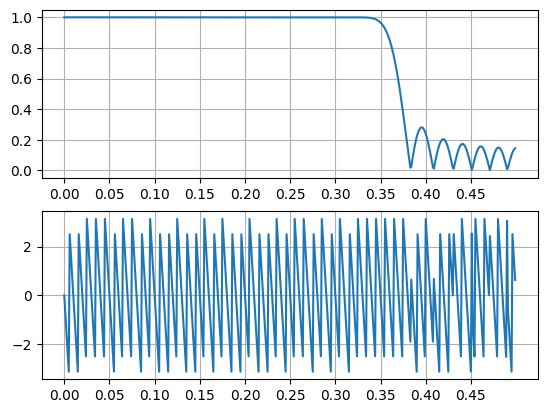

In [8]:
fig, ax = plt.subplots(2)
ax[0].plot(f_norm_test, np.abs(transf))
ax[1].plot(f_norm_test, np.angle(transf))
ax[0].set_xticks(f_norm_test[0::50])
ax[0].grid()
ax[1].set_xticks(f_norm_test[0::50])
ax[1].grid()